In [475]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from torch.utils.data import DataLoader
import galsim
from dataset import Galaxy_Dataset, get_COSMOS_Galaxy, get_LSST_PSF
from models.Unrolled_ADMM import Unrolled_ADMM
from utils import PSNR, estimate_shear

## LSST

### Define basic parameters

In [476]:
COSMOS_dir = './data/COSMOS_23.5_training_sample/'
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))

fov_pixels = 48
pixel_scale = 0.2
gal_max_shear = 0.5
seeing = 0.7
atmos_max_shear = 0.2

### Simulate PSF

In [477]:
# PSF parameters
rng = galsim.UniformDeviate(seed=294) # Initialize the random number generator
rng_gaussian = galsim.GaussianDeviate(seed=34, mean=seeing, sigma=0.18)
atmos_fwhm = 0 # arcsec (mean 0.7 for LSST)
while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
    atmos_fwhm = rng_gaussian()
atmos_e = rng() * atmos_max_shear # ellipticity of atmospheric PSF
atmos_beta = 2. * np.pi * rng()     # radians
atmos_shear = galsim.Shear(e=atmos_e, beta=atmos_beta * galsim.radians)
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 8.36 # telescope diameter / meters (8.36 for LSST, 6.5 for JWST)
pixel_scale = pixel_scale

psf = get_LSST_PSF(lam, tel_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                    atmos_fwhm, atmos_e, atmos_beta, 0, 0,
                    fov_pixels, pixel_scale=pixel_scale)   

### Simulate galaxy

In [478]:
idx = 0 # index pf galaxy in the catalog

# Galaxy parameters 
gal_e = rng() * gal_max_shear       # shear of galaxy
gal_beta = 2. * np.pi * rng()       # radians
gal_shear = galsim.Shear(e=gal_e, beta=gal_beta*galsim.radians)
gal_mu = 1 + rng() * 0.1            # mu = ((1-kappa)^2 - g1^2 - g2^2)^-1 (1.082)
theta = 2. * np.pi * rng()          # radians
sky_level = 1.e3                     # ADU / arcsec^2

gal_flux_list = [6.25e4, 2.5e4, 1e4, 0.4e4]
gt_list = []
snr_list = []
for gal_flux in gal_flux_list:                    
    gt, gal_orig = get_COSMOS_Galaxy(catalog=real_galaxy_catalog, idx=idx, 
                                        gal_flux=gal_flux, sky_level=sky_level, 
                                        gal_e=gal_e, gal_beta=gal_beta, 
                                        theta=theta, gal_mu=gal_mu, 
                                        fov_pixels=fov_pixels, pixel_scale=pixel_scale, 
                                        rng=rng)
    gt_list.append(gt)
    snr = gal_flux/np.sqrt(gal_flux + sky_level*(fov_pixels**2)*(pixel_scale**2))
    snr_list.append(snr)
    print('gal_flux={:.1f} \tSNR={:.1f}'.format(gal_flux, snr))


gal_flux=62500.0 	SNR=158.9
gal_flux=25000.0 	SNR=73.0
gal_flux=10000.0 	SNR=31.3
gal_flux=4000.0 	SNR=12.9


### Simulate Observation

In [479]:
obs_list = []
for gt in gt_list:
    # Convolution via FFT
    conv = ifftshift(ifft2(fft2(psf) * fft2(gt))).abs()
    conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero

    # Add CCD noise (Poisson + Gaussian)
    obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=2*torch.ones_like(conv))
    obs = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero
    obs = (obs - obs.min())/(obs.max() - obs.min())

    obs_list.append(obs)

### Fourier Power Function

In [480]:
rec_fourier_list = []
for obs in obs_list:
    rec_fourier = ifftshift(ifft2(fft2(obs) / fft2(psf))).abs()
    rec_fourier_list.append(rec_fourier)

In [481]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

iter_list = [1,2,4,8]
rec_admm = [[], [], [], []]
model_files = ['saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth',
               'saved_models/Poisson_PnP_2iters_LSST23.5_50epochs.pth',
               'saved_models/Poisson_PnP_4iters_LSST23.5_30epochs.pth', 
               'saved_models/Poisson_PnP_8iters_LSST23.5_35epochs.pth']#,
            #    'saved_models/Poisson_PnP_12iters_LSST23.5_25epochs.pth']
for idx, (n_iters, model_file) in enumerate(zip(iter_list, model_files)):
    model = Unrolled_ADMM(n_iters=n_iters, llh='Poisson', PnP=True)
    model.to(device)
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {model_file}.')

    for obs in obs_list:
        alpha = obs.ravel().mean()/0.33
        alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
        rec = (output.cpu() * alpha.cpu()).squeeze(dim=0).squeeze(dim=0).detach()
        rec_admm[idx].append(rec)
    

Successfully loaded in saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth.
Successfully loaded in saved_models/Poisson_PnP_2iters_LSST23.5_50epochs.pth.
Successfully loaded in saved_models/Poisson_PnP_4iters_LSST23.5_30epochs.pth.
Successfully loaded in saved_models/Poisson_PnP_8iters_LSST23.5_35epochs.pth.


### Plot Post Stamp

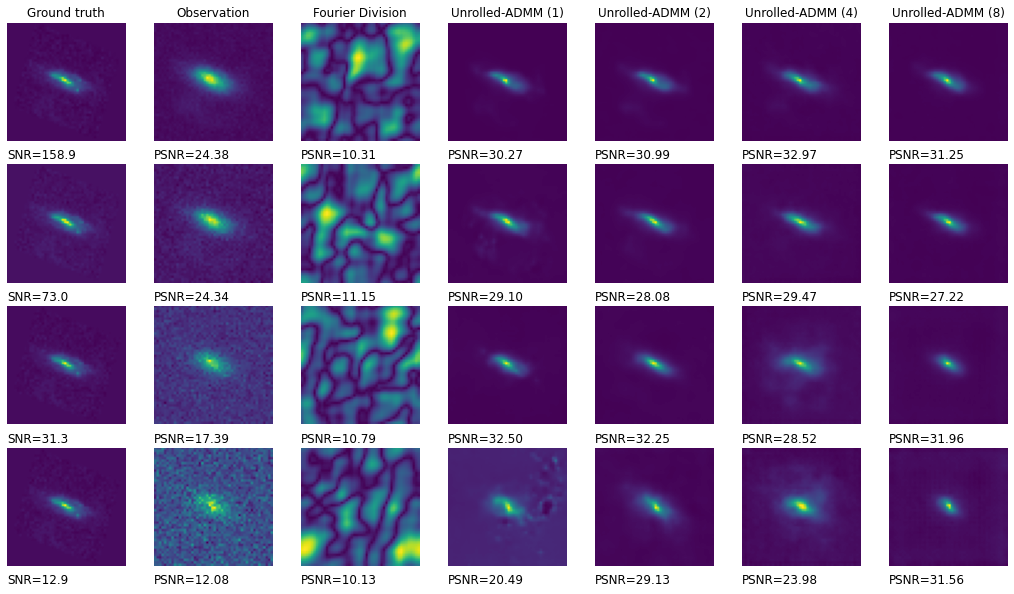

In [482]:
plt.figure(figsize=(18,10))
for idx, (gt, obs, snr, rec_fourier, rec_1, rec_2, rec_4, rec_8) in enumerate(zip(gt_list, obs_list, snr_list, rec_fourier_list, rec_admm[0], rec_admm[1], rec_admm[2], rec_admm[3])):
    plt.subplot(4,7,7*idx+1)
    plt.imshow(gt)
    plt.title("SNR={:.1f}".format(snr),y=-0.2,loc='left')
    plt.axis('off')
    if idx == 0:
        plt.title('Ground truth')

    plt.subplot(4,7,7*idx+2)
    plt.imshow(obs)
    plt.title("PSNR={:.2f}".format(PSNR(obs,gt)),y=-0.2,loc='left')
    plt.axis('off')
    if idx == 0:
        plt.title('Observation')

    plt.subplot(4,7,7*idx+3)
    plt.imshow(rec_fourier)
    plt.title("PSNR={:.2f}".format(PSNR(rec_fourier,gt)),y=-0.2,loc='left')
    plt.axis('off')
    if idx == 0:
        plt.title('Fourier Division')

    plt.subplot(4,7,7*idx+4)
    plt.imshow(rec_1)
    plt.title("PSNR={:.2f}".format(PSNR(rec_1,gt)),y=-0.2,loc='left')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM (1)')

    plt.subplot(4,7,7*idx+5)
    plt.imshow(rec_2)
    plt.title("PSNR={:.2f}".format(PSNR(rec_2,gt)),y=-0.2,loc='left')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM (2)')

    plt.subplot(4,7,7*idx+6)
    plt.imshow(rec_4)
    plt.title("PSNR={:.2f}".format(PSNR(rec_4,gt)),y=-0.2,loc='left')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM (4)')

    plt.subplot(4,7,7*idx+7)
    plt.imshow(rec_8)
    plt.title("PSNR={:.2f}".format(PSNR(rec_8,gt)),y=-0.2,loc='left')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM (8)')

plt.show()